# US Cars Dataset Price Prediction

US Cars' data was scraped from AUCTION EXPORT.com. This dataset included Information about 28 brands of clean and used vehicles for sale in US. Twelve initial features were assembled for each car in the dataset.

In [142]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import lightgbm as lgb
pd.set_option('display.max_rows', None)
plt.rcParams['figure.figsize']=(16, 8.27) #set graphs size to A4 dimensions
sns.set_style('darkgrid')

In [143]:
dataset=pd.read_csv('cars.csv')

In [144]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2499 non-null   int64  
 1   price         2499 non-null   int64  
 2   brand         2499 non-null   object 
 3   model         2499 non-null   object 
 4   year          2499 non-null   int64  
 5   title_status  2499 non-null   object 
 6   mileage       2499 non-null   float64
 7   color         2499 non-null   object 
 8   vin           2499 non-null   object 
 9   lot           2499 non-null   int64  
 10  state         2499 non-null   object 
 11  country       2499 non-null   object 
 12  condition     2499 non-null   object 
dtypes: float64(1), int64(4), object(8)
memory usage: 253.9+ KB


In [145]:
dataset.head(10)

,Unnamed: 0,price,brand,model,year,title_status,mileage,color,vin,lot,state,country,condition
0,0,6300,toyota,cruiser,2008,clean vehicle,274117.0,black,jtezu11f88k007763,159348797,new jersey,usa,10 days left
1,1,2899,ford,se,2011,clean vehicle,190552.0,silver,2fmdk3gc4bbb02217,166951262,tennessee,usa,6 days left
2,2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,3c4pdcgg5jt346413,167655728,georgia,usa,2 days left
3,3,25000,ford,door,2014,clean vehicle,64146.0,blue,1ftfw1et4efc23745,167753855,virginia,usa,22 hours left
4,4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,3gcpcrec2jg473991,167763266,florida,usa,22 hours left
5,5,5700,dodge,mpv,2018,clean vehicle,45561.0,white,2c4rdgeg9jr237989,167655771,texas,usa,2 days left
6,6,7300,chevrolet,pk,2010,clean vehicle,149050.0,black,1gcsksea1az121133,167753872,georgia,usa,22 hours left
7,7,13350,gmc,door,2017,clean vehicle,23525.0,gray,1gks2gkc3hr326762,167692494,california,usa,20 hours left
8,8,14600,chevrolet,malibu,2018,clean vehicle,9371.0,silver,1g1zd5st5jf191860,167763267,florida,usa,22 hours left
9,9,5250,ford,mpv,2017,clean vehicle,63418.0,black,2fmpk3j92hbc12542,167656121,texas,usa,2 days left


### Drop unnecessary columns 

In [146]:
dataset.drop(['Unnamed: 0','vin','lot'],axis=1,inplace=True)

### Create and transform features 

We are going to extract how many minutes left from the "Condition" column.

In [147]:
dataset['value']= dataset['condition'] .str.split(' ').str[0]
dataset['days']= dataset['condition'] .str.split(' ').str[1]

def days_to_min_converter(time):
    return int(time)*1440

def hours_to_min_converter(time):
    return int(time)*60


temp_data=pd.concat([dataset[dataset['days']=='days']['value'].apply(days_to_min_converter),
           dataset[dataset['days']=='hours']['value'].apply(hours_to_min_converter),
           dataset[dataset['days']=='minutes']['value'].astype(int)]).rename('Minutes_Left',inplace=True)



dataset=pd.concat([dataset,temp_data],axis=1)
dataset['Minutes_Left'].fillna(-200,inplace=True)

dataset.drop(['condition','value','days'],axis=1,inplace=True)

Convert the Year column to represent which year of car's registration is in progress (e.g first, second, third, etc...)

In [148]:
def year_transform(year):
    return 2021-year

dataset['year']=dataset['year'].apply(year_transform)

Create new feature which represents Mileage per Year for each car.

In [89]:
dataset['miles/year']=dataset['mileage']/dataset['year']

Find out numerical and categorical variables

In [150]:
categorical_features=[feature for feature in dataset.columns if dataset[feature].dtype=='O']

numerical_features=[feature for feature in dataset.columns if dataset[feature].dtype!='O']

# EDA

Create some visualizations and print some information about features distribution

In [151]:
dataframes=[]
for feature in categorical_features:
    dataframe=dataset[feature].value_counts().rename_axis(feature).reset_index(name='counts')
    dataframes.append(dataframe)

for i in range(len(dataframes)):
    print(dataframes[i],'\n')

              brand  counts
0              ford    1235
1             dodge     432
2            nissan     312
3         chevrolet     297
4               gmc      42
5              jeep      30
6          chrysler      18
7               bmw      17
8           hyundai      15
9               kia      13
10            buick      13
11         infiniti      12
12            honda      12
13         cadillac      10
14    mercedes-benz      10
15        heartland       5
16        peterbilt       4
17             audi       4
18             land       4
19            acura       3
20          lincoln       2
21            mazda       2
22            lexus       2
23  harley-davidson       1
24         maserati       1
25              ram       1
26           toyota       1
27           jaguar       1 

           model  counts
0           door     651
1          f-150     219
2          doors     148
3        caravan     102
4            mpv      87
5         fusion      65
6        du

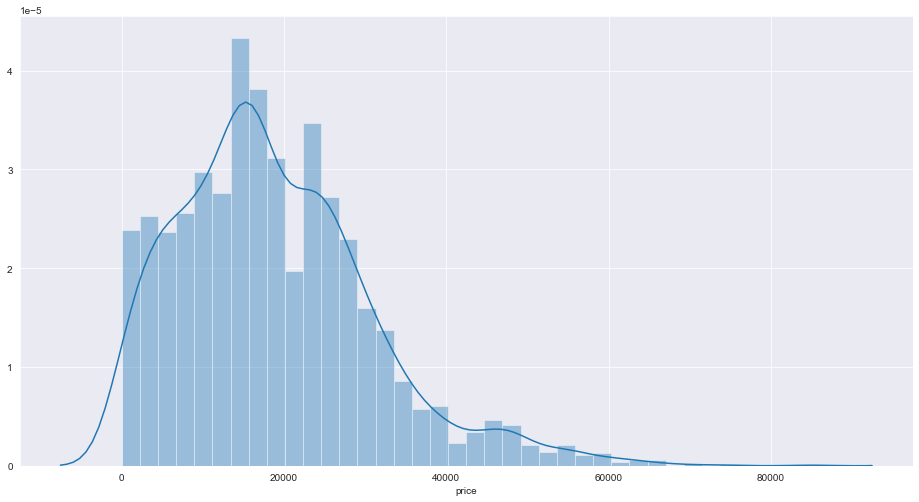

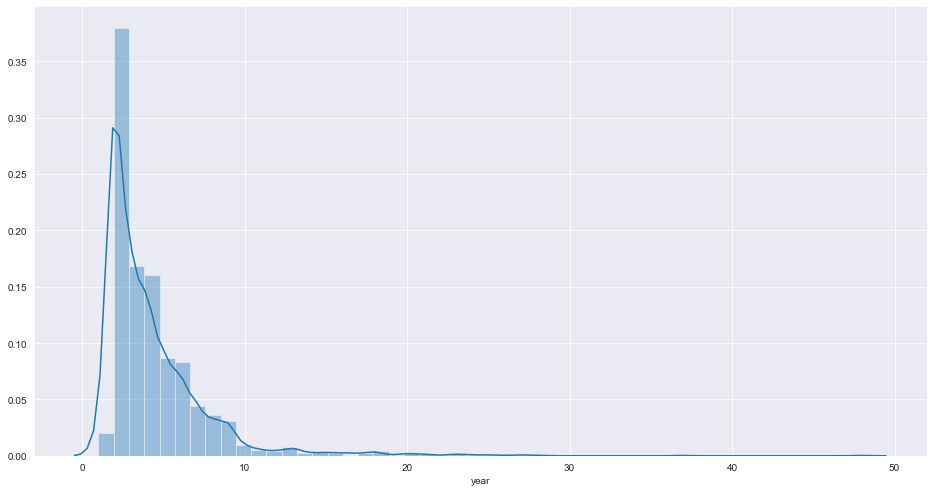

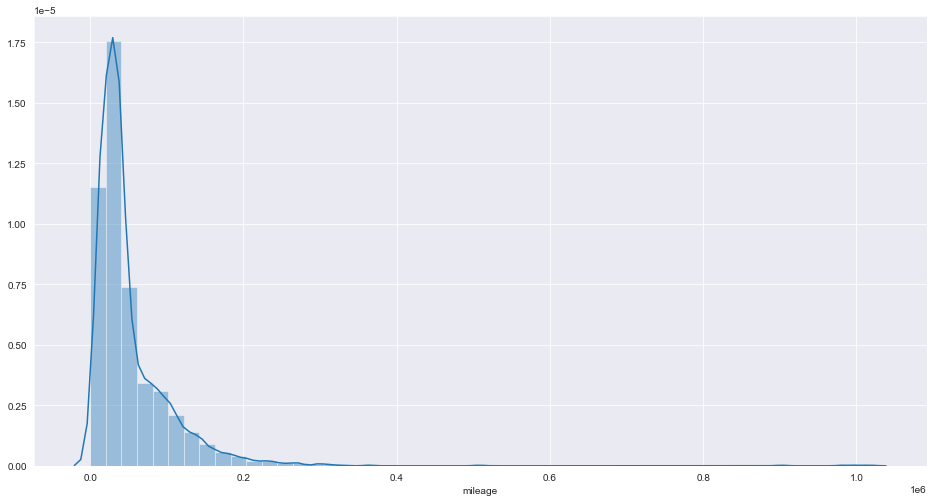

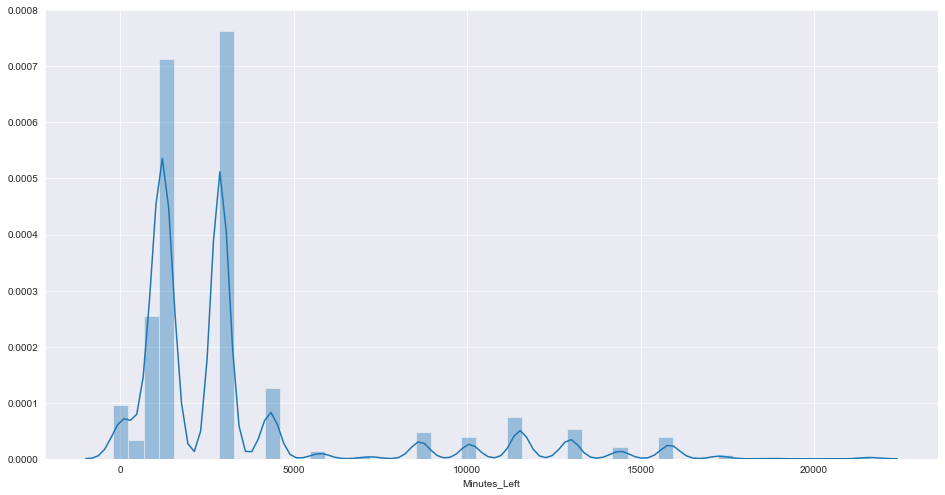

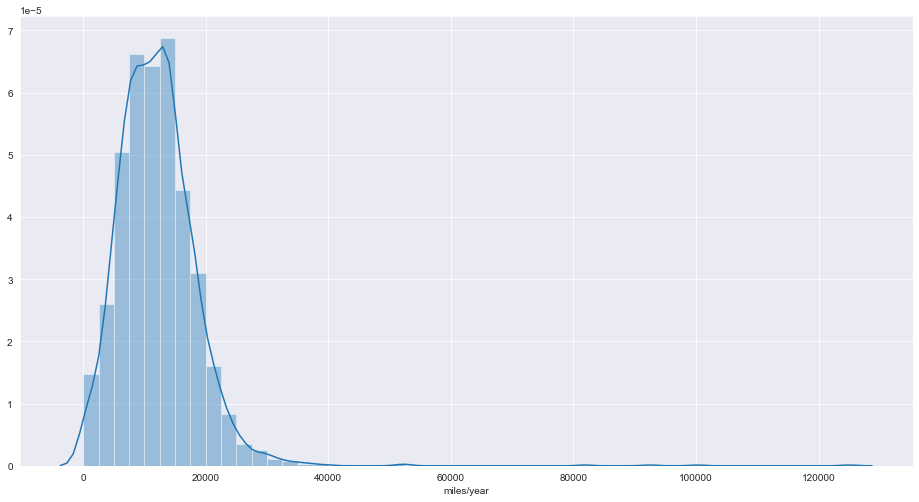

In [118]:
for feature in numerical_features:
    sns.distplot(dataset[feature])
    plt.show()

### SPLITTING DATASET TO TRAIN AND TEST SET AND APPLYING SOME FEATURE ENGINEERING TECHNIQUES

In [153]:
X=dataset.drop('price',axis=1)
y=dataset['price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

train_set=pd.concat([X_train,y_train],axis=1)
test_set=pd.concat([X_test,y_test],axis=1)

### APPLYING TARGET MEAN ENCODING FOR CATEGORICAL FEATURES AND SCALING THE TRAIN AND TEST SET

In [154]:
for feature in categorical_features:
    feature_labels=train_set.groupby(feature)['price'].mean().sort_values().index
    feature_labels={k:i for i,k in enumerate(feature_labels,0)}
    train_set[feature]=train_set[feature].map(feature_labels)
    test_set[feature]=test_set[feature].map(feature_labels)

test_set.dropna(inplace=True)

scaler=StandardScaler()

scaled_X_train=pd.DataFrame(scaler.fit_transform(train_set.drop('price',axis=1)), columns=X_train.columns)
scaled_X_train.index=train_set.index
scaled_X_test=pd.DataFrame(scaler.transform(test_set.drop('price',axis=1)), columns=X_test.columns)
scaled_X_test.index=test_set.index


scaled_train=pd.concat([scaled_X_train,train_set['price']],axis=1)
scaled_test=pd.concat([scaled_X_test,test_set['price']],axis=1)

# FEATURE SELECTION

### Now we are going to check feature importances using Random Forest 

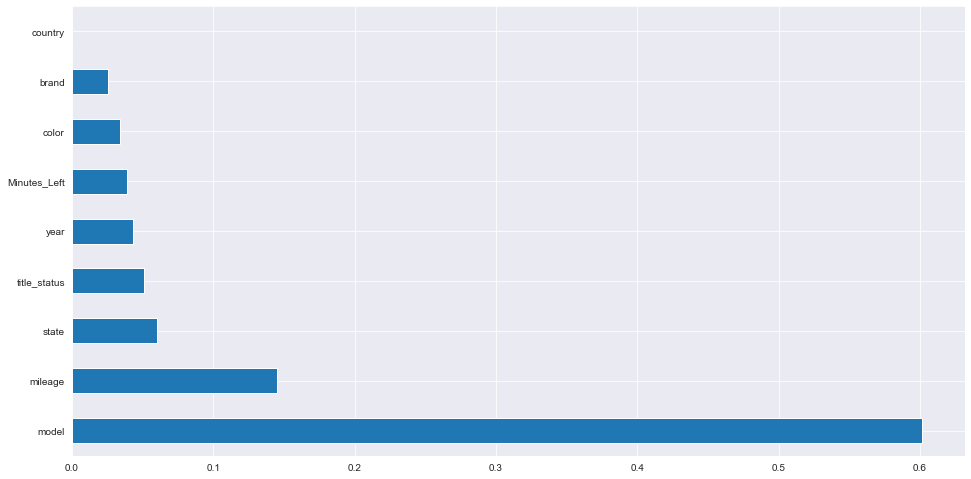

In [156]:
reg=RandomForestRegressor()
reg.fit(scaled_train.drop('price',axis=1),scaled_train['price'])

feat_importances = pd.Series(reg.feature_importances_, index=scaled_train.drop('price',axis=1).columns)
feat_importances.nlargest(scaled_train.drop('price',axis=1).shape[1]).plot(kind='barh')
plt.show()

As we can see 'Country' is not a useful feature and we drop it from train and test set

In [157]:
scaled_train.drop('country',axis=1,inplace=True)
scaled_test.drop('country',axis=1,inplace=True)

# MODEL SELECTION

In [158]:
X_train=scaled_train.drop('price',axis=1)
y_train=scaled_train['price']

X_test=scaled_test.drop('price',axis=1)
y_test=scaled_test['price']




lm=LinearRegression()
svr=SVR()
rf=RandomForestRegressor()
xgb_reg=xgb.XGBRegressor()
lgb_reg=lgb.LGBMRegressor()


score_lm=cross_val_score(lm,X_train,y_train,cv=10,scoring='neg_mean_squared_error')
score_svr=cross_val_score(svr,X_train,y_train,cv=10,scoring='neg_mean_squared_error')
score_rf=cross_val_score(rf,X_train,y_train,cv=10,scoring='neg_mean_squared_error')
score_xgb_reg=cross_val_score(xgb_reg,X_train,y_train,cv=10,scoring='neg_mean_squared_error')
score_lgb_reg=cross_val_score(lgb_reg,X_train,y_train,cv=10,scoring='neg_mean_squared_error')


scores=pd.DataFrame({'Model':['Linear Regression','SVR','Random Forest','XGBoost','LightGBM'],
                    'Mean Squared Error':[-score_lm.mean(),-score_svr.mean(),-score_rf.mean(),
                                           -score_xgb_reg.mean(),-score_lgb_reg.mean()]})

scores

,Model,Mean Squared Error
0,Linear Regression,5.848337e+07
1,SVR,1.527027e+08
2,Random Forest,3.555852e+07
3,XGBoost,3.918205e+07
4,LightGBM,3.787296e+07


We are going to evaluate and apply Hyper Parameter tuning for Random Forest only.

#### Evaluating the model's performance on the test set

In [74]:
rf.fit(X_train,y_train)
y_pred_rf=rf.predict(X_test)

print('MSE: ',mean_squared_error(y_test,y_pred_rf))
print('R2: ',r2_score(y_test,y_pred_rf))
print('MAE: ',mean_absolute_error(y_test,y_pred_rf))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y_pred_rf)))

MSE:  34469847.54688078
R2:  0.7325855423247465
MAE:  3651.4944421487603
RMSE:  5871.102753902437


#### Hyperparameter tuning for Random Forest

In [72]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4,8,16,32]

#learning_rate = [0.1, 0.01, 0.001]

# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               #'learning_rate':learning_rate,
               'min_samples_leaf':min_samples_leaf,
               'bootstrap': bootstrap}




random_rf=RandomizedSearchCV(rf,cv=10,param_distributions=random_grid,scoring='neg_mean_squared_error',n_jobs=-1,verbose=1)
random_rf.fit(X_train,y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

#### Εvaluating best model's performance according to hyperparameter tuning

In [159]:
best_rf=random_rf.best_estimator_
best_rf.fit(X_train,y_train)
y_pred_bestrf=best_rf.predict(X_test)

print('MSE: ',mean_squared_error(y_test,y_pred_bestrf))
print('R2: ',r2_score(y_test,y_pred_bestrf))
print('MAE: ',mean_absolute_error(y_test,y_pred_bestrf))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y_pred_bestrf)))

MSE:  30377605.975035235
R2:  0.7643328414424135
MAE:  3482.540912957637
RMSE:  5511.588335047823


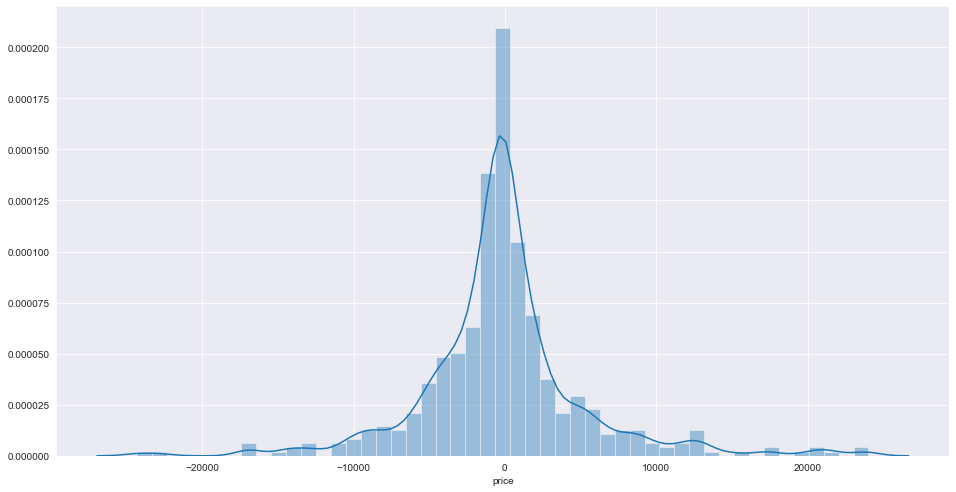

In [160]:
sns.distplot(y_test-y_pred_bestrf)
plt.show()

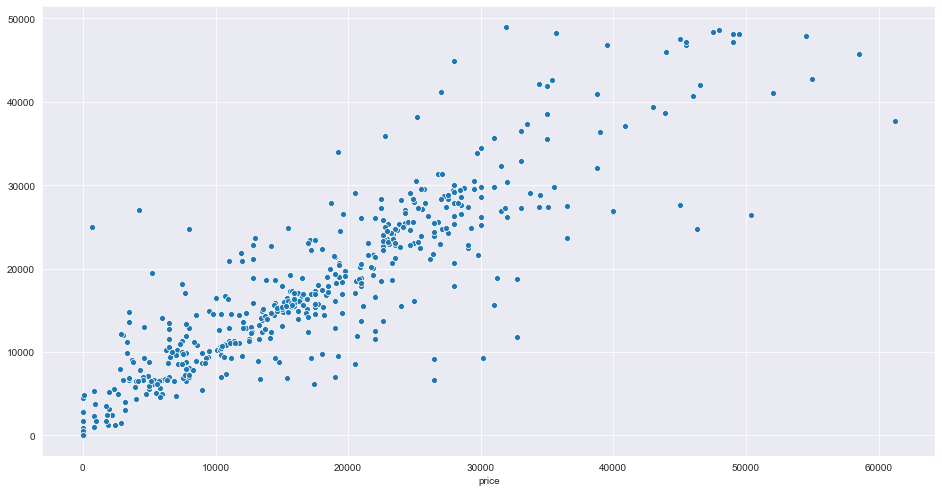

In [161]:
sns.scatterplot(y_test,y_pred_bestrf)
plt.show()

From the scatterplot above we see that relationship between actual and predicted values tends to be linear, so we have built a good model.